<a href="https://colab.research.google.com/github/Sankoku/Human-Machine/blob/main/lab1_LM_Liashenko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2. Ляшенко Роман - Blog author gender classification data set  (http://www.cs.uic.edu/~liub/FBS/blog-gender-dataset.rar)

In [ ]:
!pip install nltk

In [ ]:
!wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/comparative_sentences.zip

--2025-06-01 19:54:13--  https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/comparative_sentences.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279121 (273K) [application/zip]
Saving to: ‘comparative_sentences.zip’

comparative_sentenc 100%[===================>] 272.58K  --.-KB/s    in 0.02s   

2025-06-01 19:54:13 (12.3 MB/s) - ‘comparative_sentences.zip’ saved [279121/279121]



In [ ]:
!unzip comparative_sentences.zip

Archive:  comparative_sentences.zip
   creating: comparative_sentences/
  inflating: comparative_sentences/labeledSentences.txt  
  inflating: comparative_sentences/listOfkeywords.txt  
  inflating: comparative_sentences/README.txt  


In [ ]:
# Лабораторна робота №1: Застосування логістичної регресії для аналізу тональності текстів
# Датасет: Comparative Sentence Dataset

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk

# Завантаження NLTK компонентів
print("Завантаження NLTK компонентів...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

print("Всі бібліотеки завантажено успішно!")

# Список ключових слів для визначення порівняльних речень
COMPARATIVE_KEYWORDS = {
    'beat', 'inferior', 'outstrip', 'both', 'on par with', 'choice', 'choose', 'prefer',
    'recommend', 'outperform', 'superior', 'all', 'up against', 'less', 'favor', 'defeat',
    'twice', 'thrice', 'half', 'same', 'either', 'compete', 'number one', 'one of few',
    'more', 'like', 'behind', 'similar', 'identical', 'versus', 'first', 'outdistance',
    'before', 'double', 'outsell', 'nobody', 'vs', 'last', 'after', 'improve', 'equal',
    'equivalent', 'together', 'altogether', 'alternate', 'only', 'outmatch', 'ahead',
    'fraction', 'outdo', 'match', 'unmatched', 'peerless', 'differ', 'outwit', 'rival',
    'compare', 'top', 'exceed', 'lead', 'win', 'outstrip', 'none', 'near', 'unrivaled',
    'dominate', 'second', 'nonpareil', 'advantage', 'unlike', 'least', 'outclass',
    'outfox', 'outdistance', 'most', 'better', 'worse', 'best', 'worst', 'than',
    'compared', 'comparison', 'rather than', 'as good as', 'as bad as', 'faster',
    'slower', 'bigger', 'smaller', 'higher', 'lower', 'greater', 'lesser'
}

def is_comparative_sentence(sentence):
    """Визначає, чи є речення порівняльним на основі ключових слів"""
    sentence_lower = sentence.lower()

    # Перевірка на наявність ключових слів
    for keyword in COMPARATIVE_KEYWORDS:
        if keyword in sentence_lower:
            return True

    # Перевірка на граматичні форми (comparative adjectives/adverbs)
    comparative_patterns = [
        r'\b\w+er\s+than\b',  # bigger than, faster than
        r'\bmore\s+\w+\s+than\b',  # more beautiful than
        r'\bless\s+\w+\s+than\b',  # less important than
        r'\bas\s+\w+\s+as\b',  # as good as
        r'\bthe\s+\w+est\b',  # the biggest, the fastest
        r'\bmost\s+\w+\b',  # most beautiful
        r'\bleast\s+\w+\b',  # least important
    ]

    for pattern in comparative_patterns:
        if re.search(pattern, sentence_lower):
            return True

    return False

Завантаження NLTK компонентів...
Всі бібліотеки завантажено успішно!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Завантаження датасету...
Завантажено 6691 речень
Порівняльних речень: 3276
Не порівняльних речень: 3415

Після балансування:
Загалом речень: 6552
Порівняльних: 3276
Не порівняльних: 3276

Приклади речень:

Порівняльні речення (label=1):
- repost from january 13 , 2004 with a better fit title .
- does your apex dvd player only play dvd audio without video ?
- before you try to return the player or waste hours calling apex tech support , or run the player over with your car , try these simple troubleshooting ideas first .
- if you tossed it out the window , you need to fetch it .
- you need the remote control for this so you better get it from your dog before he burries it in the backyard .

Не порівняльні речення (label=0):
- dvd player:     Apex AD2600 Progressive-scan DVD player
- troubleshooting ad-2500 and ad-2600 no picture scrolling b/w .
- or does it play audio and video but scrolling in black and white ?
- hopefully you still have the remote control .
- using the remote control 

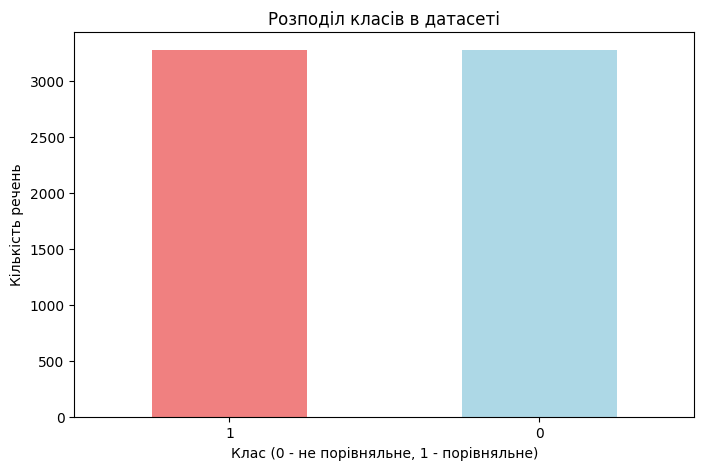

In [ ]:
def load_comparative_dataset():
    """
    Завантажує та обробляє Comparative Sentence Dataset
    """
    print("Завантаження датасету...")

    sentences = []
    labels = []

    try:
        with open('comparative_sentences/labeledSentences.txt', 'r', encoding='latin-1') as f:
            content = f.read()
    except FileNotFoundError:
        print("Файл labeledSentences.txt не знайдено!")
        print("Перевірте, чи файли розархівовано в папку comparative_sentences/")
        return None, None

    # Розділення на рядки
    lines = content.split('\n')

    current_sentence = ""
    in_comparative = False

    for line in lines:
        line = line.strip()

        # Пропускаємо порожні рядки та метадані
        if not line or line.startswith('Type:') or line.startswith('entity') or line.startswith('feature') or '_' in line:
            continue

        # Визначення початку порівняльного речення
        if line.startswith('<cs-'):
            in_comparative = True
            # Витягуємо текст з тегу
            if '>' in line and '</' in line:
                start = line.find('>') + 1
                end = line.find('</', start)
                current_sentence = line[start:end].strip()
                if current_sentence:
                    sentences.append(current_sentence)
                    labels.append(1)  # Порівняльне речення
            continue

        # Закінчення порівняльного речення
        elif line.startswith('</cs-'):
            in_comparative = False
            continue

        # Звичайні речення (не порівняльні)
        elif not in_comparative and len(line) > 15 and not line.startswith('<') and not line.startswith('1_') and not line.startswith('2_') and not line.startswith('3_'):
            # Додаткова фільтрація для якості даних
            if any(char.isalpha() for char in line) and len(line.split()) >= 3:
                sentences.append(line)

                # Перевіряємо на ключові слова для додаткової точності
                if is_comparative_sentence(line):
                    labels.append(1)  # Порівняльне
                else:
                    labels.append(0)  # Не порівняльне

    print(f"Завантажено {len(sentences)} речень")
    print(f"Порівняльних речень: {sum(labels)}")
    print(f"Не порівняльних речень: {len(labels) - sum(labels)}")

    # Балансування датасету для кращої якості навчання
    if sum(labels) > 0 and (len(labels) - sum(labels)) > 0:
        # Створюємо збалансований датасет
        pos_sentences = [s for s, l in zip(sentences, labels) if l == 1]
        neg_sentences = [s for s, l in zip(sentences, labels) if l == 0]

        # Обмежуємо кількість до меншого класу * 2
        min_class_size = min(len(pos_sentences), len(neg_sentences))
        max_samples = min_class_size * 2

        balanced_sentences = pos_sentences[:max_samples//2] + neg_sentences[:max_samples//2]
        balanced_labels = [1] * (max_samples//2) + [0] * (max_samples//2)

        print(f"\nПісля балансування:")
        print(f"Загалом речень: {len(balanced_sentences)}")
        print(f"Порівняльних: {sum(balanced_labels)}")
        print(f"Не порівняльних: {len(balanced_labels) - sum(balanced_labels)}")

        return balanced_sentences, balanced_labels

    return sentences, labels

# Завантаження даних
sentences, labels = load_comparative_dataset()

if sentences is not None and len(sentences) > 0:
    # Перетворення у DataFrame для зручності
    df = pd.DataFrame({
        'sentence': sentences,
        'label': labels
    })

    print("\nПриклади речень:")
    print("\nПорівняльні речення (label=1):")
    comparative_examples = df[df['label'] == 1].head(5)
    for i, row in comparative_examples.iterrows():
        print(f"- {row['sentence']}")

    print("\nНе порівняльні речення (label=0):")
    non_comparative_examples = df[df['label'] == 0].head(5)
    for i, row in non_comparative_examples.iterrows():
        print(f"- {row['sentence']}")

    # Статистика датасету
    print(f"\nСтатистика датасету:")
    print(f"Загальна кількість речень: {len(df)}")
    print(f"Розподіл класів:")
    print(df['label'].value_counts())

    # Візуалізація розподілу класів
    plt.figure(figsize=(8, 5))
    df['label'].value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
    plt.title('Розподіл класів в датасеті')
    plt.xlabel('Клас (0 - не порівняльне, 1 - порівняльне)')
    plt.ylabel('Кількість речень')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
# Попередня обробка тексту
def process_sentence(sentence):
    """
    Попередня обробка речення:
    - Видалення знаків пунктуації
    - Приведення до нижнього регістру
    - Токенізація
    - Видалення стоп-слів
    - Лематизація
    """
    if not sentence:
        return []

    # Видалення URL, згадок, хештегів
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'@\w+|#\w+', '', sentence)

    # Видалення знаків пунктуації та цифр
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)

    # Приведення до нижнього регістру
    sentence = sentence.lower()

    # Токенізація
    tokens = word_tokenize(sentence)

    # Видалення стоп-слів
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Лематизація
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Побудова частотного словника
def build_freqs(sentences, labels):
    """
    Створює частотний словник у форматі:
    {(слово, мітка): частота}
    """
    freqs = defaultdict(int)

    for sentence, label in zip(sentences, labels):
        words = process_sentence(sentence)
        for word in words:
            pair = (word, float(label))
            freqs[pair] += 1

    return dict(freqs)

if sentences is not None and len(sentences) > 0:
    # Приклад обробки тексту
    sample_text = "The Canon camera has better image quality than the Nikon model."
    processed = process_sentence(sample_text)
    print(f"\nПриклад обробки тексту:")
    print(f"Оригінал: {sample_text}")
    print(f"Після обробки: {processed}")

    # Створення частотного словника
    print("\nСтворення частотного словника...")
    freq_dict = build_freqs(sentences, labels)

    # Аналіз найчастотніших слів
    pos_words = [(word, freq) for (word, label), freq in freq_dict.items() if label == 1.0]
    neg_words = [(word, freq) for (word, label), freq in freq_dict.items() if label == 0.0]

    pos_words_sorted = sorted(pos_words, key=lambda x: x[1], reverse=True)
    neg_words_sorted = sorted(neg_words, key=lambda x: x[1], reverse=True)

    print(f"\nСтворено словник з {len(freq_dict)} унікальних пар (слово, мітка)")


Приклад обробки тексту:
Оригінал: The Canon camera has better image quality than the Nikon model.
Після обробки: ['canon', 'camera', 'better', 'image', 'quality', 'nikon', 'model']

Створення частотного словника...

Створено словник з 10250 унікальних пар (слово, мітка)


In [ ]:
# Видобування ознак
def extract_features(sentence, freq_dict):
    """
    Перетворює речення у числовий вектор [bias, sum_pos, sum_neg]
    """
    words = process_sentence(sentence)

    # Ініціалізація вектору ознак
    x = np.zeros(3)
    x[0] = 1  # bias term

    # Підрахунок частот для позитивного та негативного класів
    for word in words:
        x[1] += freq_dict.get((word, 1.0), 0)  # частота в порівняльних реченнях
        x[2] += freq_dict.get((word, 0.0), 0)  # частота в не порівняльних реченнях

    return x

In [ ]:
# Реалізація логістичної регресії
class LogisticRegression:
    def __init__(self, learning_rate=1e-8, num_iterations=1500):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.costs = []

    def sigmoid(self, z):
        """
        Сигмоїдна функція активації
        """
        # Обмеження для числової стабільності
        z = np.clip(z, -250, 250)
        return 1.0 / (1.0 + np.exp(-z))

    def compute_cost(self, y_true, y_pred):
        """
        Обчислення логарифмічної функції втрат
        """
        m = len(y_true)
        # Додаємо малу константу для уникнення log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        cost = -1/m * (np.dot(y_true.T, np.log(y_pred)) +
                       np.dot((1-y_true).T, np.log(1-y_pred)))
        return cost[0][0]

    def fit(self, X, y):
        """
        Навчання моделі методом градієнтного спуску
        """
        m, n = X.shape

        # Ініціалізація параметрів
        self.theta = np.zeros((n, 1))
        y = y.reshape(-1, 1)

        print("Початок навчання моделі...")
        print(f"Розмір навчальної вибірки: {m} зразків, {n} ознак")

        for i in range(self.num_iterations):
            # Пряме поширення
            z = np.dot(X, self.theta)
            y_pred = self.sigmoid(z)

            # Обчислення функції втрат
            cost = self.compute_cost(y, y_pred)
            self.costs.append(cost)

            # Обчислення градієнта
            dJ = 1/m * np.dot(X.T, (y_pred - y))

            # Оновлення параметрів
            self.theta = self.theta - self.learning_rate * dJ

            # Виведення прогресу
            if i % 200 == 0:
                print(f"Ітерація {i}, втрати: {cost:.6f}")

        print(f"Навчання завершено! Фінальні втрати: {self.costs[-1]:.6f}")
        print(f"Фінальні параметри: {self.theta.flatten()}")

    def predict_proba(self, X):
        """
        Передбачення ймовірностей
        """
        z = np.dot(X, self.theta)
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        """
        Передбачення класів
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)


ПІДГОТОВКА ДАНИХ ТА НАВЧАННЯ МОДЕЛІ
Унікальні мітки в датасеті: [0 1]
Розмір навчальної вибірки: 5241
Розмір тестової вибірки: 1311
Розподіл класів у навчальній вибірці: [2620 2621]
Розподіл класів у тестовій вибірці: [656 655]

Створення матриці ознак для навчальної вибірки...
Створення матриці ознак для тестової вибірки...
Розмір матриці ознак: (5241, 3)
Початок навчання моделі...
Розмір навчальної вибірки: 5241 зразків, 3 ознак
Ітерація 0, втрати: 0.693147
Ітерація 200, втрати: 0.673166
Ітерація 400, втрати: 0.668695
Ітерація 600, втрати: 0.665642
Ітерація 800, втрати: 0.662810
Ітерація 1000, втрати: 0.660079
Ітерація 1200, втрати: 0.657434
Ітерація 1400, втрати: 0.654871
Ітерація 1600, втрати: 0.652385
Ітерація 1800, втрати: 0.649976
Навчання завершено! Фінальні втрати: 0.647651
Фінальні параметри: [-1.37740256e-05  1.91110639e-03 -1.53833309e-03]


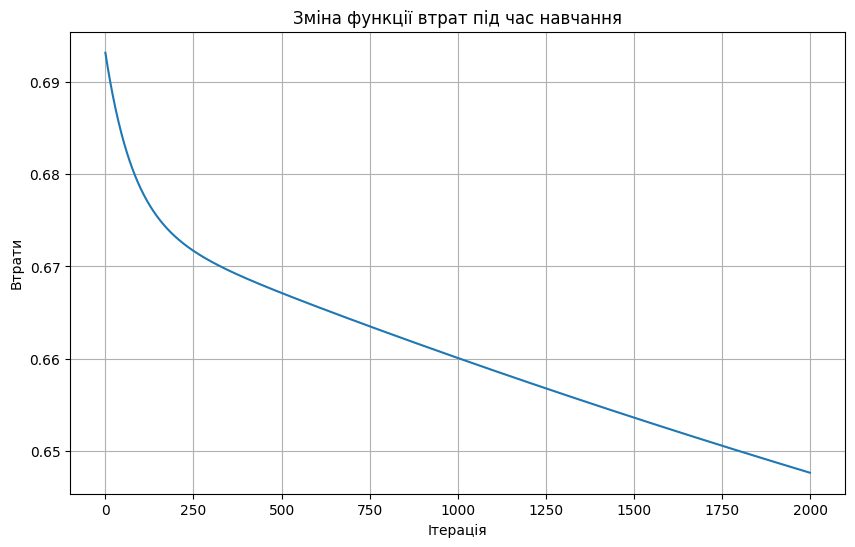


ОЦІНКА ЯКОСТІ МОДЕЛІ
Точність на навчальній вибірці: 0.5493 (54.93%)
Точність на тестовій вибірці: 0.5408 (54.08%)
Унікальні класи в тестових передбаченнях: [0 1]
Унікальні класи в тестових мітках: [0 1]

Детальний звіт про класифікацію (тестова вибірка):
                precision    recall  f1-score   support

Не порівняльне       1.00      0.08      0.15       656
   Порівняльне       0.52      1.00      0.69       655

      accuracy                           0.54      1311
     macro avg       0.76      0.54      0.42      1311
  weighted avg       0.76      0.54      0.42      1311



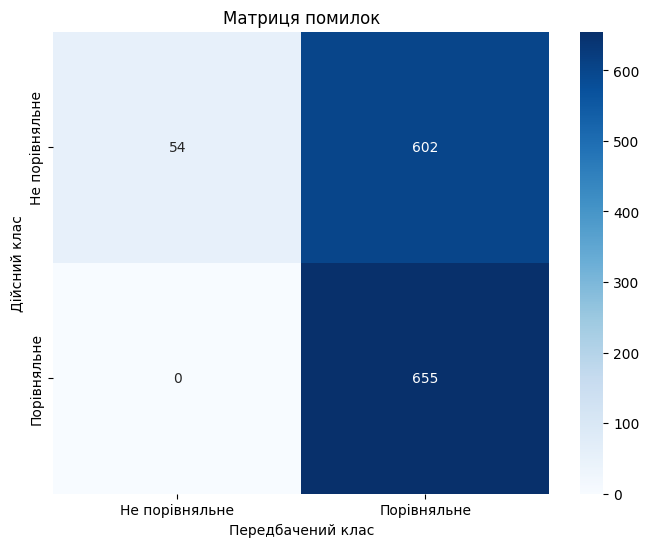


ТЕСТУВАННЯ НА ВЛАСНИХ ПРИКЛАДАХ

Речення: 'This camera is better than that one.'
Ймовірність порівняльності: 0.653
Класифікація: Порівняльне

Речення: 'The weather is nice today.'
Ймовірність порівняльності: 0.502
Класифікація: Не порівняльне

Речення: 'Canon has superior image quality compared to Nikon.'
Ймовірність порівняльності: 0.550
Класифікація: Порівняльне

Речення: 'I like to read books.'
Ймовірність порівняльності: 0.641
Класифікація: Порівняльне

Речення: 'The new model outperforms the previous version.'
Ймовірність порівняльності: 0.539
Класифікація: Порівняльне

Речення: 'She went to the store yesterday.'
Ймовірність порівняльності: 0.509
Класифікація: Не порівняльне

Речення: 'AMD processors are faster than Intel processors.'
Ймовірність порівняльності: 0.644
Класифікація: Порівняльне

Речення: 'The meeting starts at 3 PM.'
Ймовірність порівняльності: 0.506
Класифікація: Не порівняльне

Речення: 'iPhone vs Samsung: which is better?'
Ймовірність порівняльності: 0.545
Клас

In [ ]:
# Підготовка даних та навчання моделі
if sentences is not None and len(sentences) > 0:
    print("\n" + "="*50)
    print("ПІДГОТОВКА ДАНИХ ТА НАВЧАННЯ МОДЕЛІ")
    print("="*50)

    # Перевірка наявності обох класів
    unique_labels = np.unique(labels)
    print(f"Унікальні мітки в датасеті: {unique_labels}")

    if len(unique_labels) < 2:
        print("❌ Увага: В датасеті присутній тільки один клас!")
        print("Це може вказувати на проблеми з обробкою даних.")
    else:
        # Розділення на навчальну та тестову вибірки
        X_sentences, X_test_sentences, y_train, y_test = train_test_split(
            sentences, labels, test_size=0.2, random_state=42, stratify=labels
        )

        print(f"Розмір навчальної вибірки: {len(X_sentences)}")
        print(f"Розмір тестової вибірки: {len(X_test_sentences)}")
        print(f"Розподіл класів у навчальній вибірці: {np.bincount(y_train)}")
        print(f"Розподіл класів у тестовій вибірці: {np.bincount(y_test)}")

        # Перетворення речень у матрицю ознак
        print("\nСтворення матриці ознак для навчальної вибірки...")
        X_train = np.array([extract_features(sentence, freq_dict)
                           for sentence in X_sentences])

        print("Створення матриці ознак для тестової вибірки...")
        X_test = np.array([extract_features(sentence, freq_dict)
                          for sentence in X_test_sentences])

        print(f"Розмір матриці ознак: {X_train.shape}")

        # Навчання моделі
        model = LogisticRegression(learning_rate=1e-7, num_iterations=2000)
        model.fit(X_train, np.array(y_train))

        # Візуалізація процесу навчання
        plt.figure(figsize=(10, 6))
        plt.plot(model.costs)
        plt.title('Зміна функції втрат під час навчання')
        plt.xlabel('Ітерація')
        plt.ylabel('Втрати')
        plt.grid(True)
        plt.show()

        # Оцінка якості моделі
        print("\n" + "="*50)
        print("ОЦІНКА ЯКОСТІ МОДЕЛІ")
        print("="*50)

        # Передбачення на навчальній вибірці
        train_predictions = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)

        # Передбачення на тестовій вибірці
        test_predictions = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_predictions)

        print(f"Точність на навчальній вибірці: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
        print(f"Точність на тестовій вибірці: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

        # Перевірка наявності обох класів в тестових передбаченнях
        unique_test_pred = np.unique(test_predictions)
        unique_test_true = np.unique(y_test)

        print(f"Унікальні класи в тестових передбаченнях: {unique_test_pred}")
        print(f"Унікальні класи в тестових мітках: {unique_test_true}")

        # Детальний звіт про класифікацію (тільки якщо є обидва класи)
        if len(unique_test_pred) > 1 and len(unique_test_true) > 1:
            print("\nДетальний звіт про класифікацію (тестова вибірка):")
            print(classification_report(y_test, test_predictions,
                                      target_names=['Не порівняльне', 'Порівняльне']))

            # Матриця помилок
            cm = confusion_matrix(y_test, test_predictions)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Не порівняльне', 'Порівняльне'],
                        yticklabels=['Не порівняльне', 'Порівняльне'])
            plt.title('Матриця помилок')
            plt.xlabel('Передбачений клас')
            plt.ylabel('Дійсний клас')
            plt.show()
        else:
            print("⚠️ Неможливо створити повний звіт - не всі класи представлені")

        # Тестування на власних прикладах
        def test_custom_sentences(model, freq_dict, sentences_to_test):
            """
            Тестування моделі на власних прикладах
            """
            print("\n" + "="*50)
            print("ТЕСТУВАННЯ НА ВЛАСНИХ ПРИКЛАДАХ")
            print("="*50)

            for sentence in sentences_to_test:
                # Витягування ознак
                features = extract_features(sentence, freq_dict)
                features = features.reshape(1, -1)

                # Передбачення
                probability = model.predict_proba(features)[0][0]
                prediction = "Порівняльне" if probability > 0.53 else "Не порівняльне"

                print(f"\nРечення: '{sentence}'")
                print(f"Ймовірність порівняльності: {probability:.3f}")
                print(f"Класифікація: {prediction}")

        # Приклади для тестування
        test_sentences = [
            "This camera is better than that one.",
            "The weather is nice today.",
            "Canon has superior image quality compared to Nikon.",
            "I like to read books.",
            "The new model outperforms the previous version.",
            "She went to the store yesterday.",
            "AMD processors are faster than Intel processors.",
            "The meeting starts at 3 PM.",
            "iPhone vs Samsung: which is better?",
            "Coffee tastes good in the morning."
        ]

        test_custom_sentences(model, freq_dict, test_sentences)